In [1]:
import requests
from urllib.request import urlopen
from urllib.parse import urlencode,unquote,quote_plus
import urllib
import lxml
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import time
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns

In [170]:
info2_df = pd.read_excel("estate.xlsx")
info2_df.columns = ["ID","title","주문","이유"]
info2_df = info2_df.drop(info2_df[info2_df["이유"].isna()].index)
info2_df

,ID,title,주문,이유
0,6145,대구지방법원 2003. 12. 16 선고 2002가합15041 판결 [손해배상(기) ],"주 문\n1.피고는 원고에게 금 361,289,030원 및 이에 대하여 2002.1...","이 유1.기초사실\n다음 각 사실은 당사자 사이에 다툼이 없거나 갑 제1호증의 1,..."
1,4100,대전지방법원 2011. 6. 10 선고 2010가합11839 판결 [손해배상(기) ],"주 문\n1. 피고는 원고에게 41,122,400원 및 이에 대하여 2010. 11...",이 유1. 기초사실\n가. 디앤디산업개발 주식회사(이하 ‘디앤디산업개발’이라 한다)...
2,7,"서울중앙지방법원 2015. 6. 5 선고 2014가합536696, 2014가합569...","주 문\n1. 피고들은 공동하여,\n가. 원고 C에게 서울 서초구 J 철근콘크리트구...",이 유1. 기초사실가. 원고들은 아래와 같이 서울 서초구 K 소재 집합건물인 L(지...
3,8,의정부지방법원고양지원 2015. 2. 4 선고 2013가합5374 판결 [손해배상등...,【주 문】\n1. 원고(반소피고)의 본소청구 및 피고(반소원고)의 반소청구를 모두 ...,【이 유】1. 기초 사실가. 소외 1은 1997. 6. 24. 고양시 (주소 생략)...
4,6155,서울지방법원 2003. 11. 12 선고 2002가합3921 판결 [손해배상(기) ],주문\n1. 원고들 및 원고 석▲혜의 승계참가인의 피고들에 대한 청구를 모두 기각한...,"이유1.기초사실\n다음 사실은 당사자 사이에 다툼이 없거나, 갑 제1호증의 1,2,..."
...,...,...,...,...
662,2034,수원지방법원여주지원 2020. 3. 24 선고 2019가단54912 판결 [손해배상...,주문\n1. 원고의 청구를 기각한다.\n2. 소송비용은 원고가 부담한다.,이유1. 기초 사실가. 원고는 2014. 11. 19. 부친인 망 C로부터 여주시 ...
663,2035,서울중앙지방법원 2020. 3. 23 선고 2019가단5072287 판결 [손해배상...,"주문\n1. 피고는 원고에게 19,454,400원 및 이에 대하여 2017. 4. ...",이유1. 인정사실가. 원고는 다가구주택인 별지 목록 기재 부동산(이하 '이 사건 부...
664,6131,서울지방법원 2004. 1. 28 선고 2002가합86693 판결 [손해배상(기) ],주문\n1. 피고 곽ㅇㅇ은 원고에게 5억 원 및 이에 대한 2003. 1. 10.부...,"이유1. 기초사실\n[증거] 다툼없는 사실, 갑 2호증의 1, 2의 각 기재, 변론..."
665,2039,인천지방법원 2020. 2. 14 선고 2018가합58966 판결 [손해배상(기)],주문\n1. 원고들의 피고들에 대한 청구를 모두 기각한다.\n2. 소송비용은 원고들...,이유1. 기초사실가. 원고들1)\n은 2017. 3. 30. 피고들로부터 피고 D ...


In [2]:
판례목록_df = pd.read_html("법령검색목록.html")
판례목록_df = 판례목록_df[0]
# # 판례목록_df = 판례목록_df[(판례목록_df["판결유형"] == "민사") | (판례목록_df["판결유형"] == "일반행정") | (판례목록_df["판결유형"] == "가사") | (판례목록_df["판결유형"] == "세무")]
판례목록_df = 판례목록_df[(판례목록_df["판결유형"] == "민사")]
# for i in 판례목록_df["판례ID"]:
#     print("https://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID={}&type=HTML".format(i))
set(판례목록_df["제목"])
    

{nan,
 '탈퇴무효확인',
 '토지소유권이전청구소송',
 '토지차임',
 '임차보증금반환·건물인도',
 '징계면직무효확인등',
 '부동산소유권확인',
 '압류및전부명령',
 '표장사용중지가처분',
 '주식양도무효',
 '임대료',
 '유체동산가압류이의',
 '방해배제등',
 '건물명도,건물철거등',
 '주식매수선택권부여결의등부존재확인',
 '개발비등',
 '소유권말소등기·소유권말소등기',
 '지분권이전등기',
 '주민총회결의 무효확인',
 '연대채무부존재확인',
 '담장철거등·소유권이전등기',
 '부당이득·부당이득금',
 '징계면직처분취소',
 '노동조합설립무효확인',
 '주차장관리·운영권확인청구의소',
 '부당이득금반환·부당이득금·부당이득금',
 '의장등록명의자말소',
 '채무부존재등',
 '등기관처분이의',
 '면허명의변경등',
 '대지권이전등기등',
 '손해배상(기)·공사대금',
 '교섭대표노동조합지위확인',
 '연월차수당지급',
 '지료·지료',
 '임대료등',
 '계파부존재확인',
 '구상금등·부당이득금반환',
 '협정무효확인',
 '정리채권에대한부인의소',
 '건물철거등·주위토지통행권확인',
 '소유권이전등기말소,손해배상',
 '소유권이전등기·가등기말소',
 '은익재산확인등',
 '전부결정,채권압류',
 '선박우선채권부존재확인',
 '해고 무효확인',
 '엘피지집단공급시설소유권확인·가스공급시설의철거청구',
 '명의신탁해지로인한소유권이전등기',
 '건물철거,건물매매대금등',
 '공유지분이전등기말소·소유권이전등기말소',
 '종업원지위확인·종업원지위',
 '경정',
 '명의변경',
 '이익배당금',
 '관리단집회회장등직무집행정지가처분',
 '소유권이전등기및근저당권일부말소',
 '업무방해금지가처분',
 '건물명도등·소유권이전등기',
 '전기간선시설설치비반환·공사비',
 '건물명도,소유권확인등',
 '특허출원인명의변경·손해배상(지)',
 '예치금 반환',
 '소유권이전등기말소',
 '신탁재산반환·공탁금출급청구권확인',
 '반론보도심판청구',
 '손해배상(

In [3]:
판례목록_하등_df = pd.read_html("법령검색목록(1).html")
판례목록_하등_df = 판례목록_하등_df[0]
name_list = [str(i) for i in 판례목록_하등_df["제목"] if "손해배상" in str(i)]
name_list = list(set(name_list))
손해배상_하등_df = 판례목록_하등_df[판례목록_하등_df["제목"] == name_list[0]]
손해배상_하등_df
for idx,i in enumerate(name_list):
    if idx==0:
        continue
    손해배상_하등_df = 손해배상_하등_df.append((판례목록_하등_df[판례목록_하등_df["제목"] == i]),ignore_index=True)
손해배상_하등_df

,순번,판례ID,제목,법원,사건유형,판결유형,선고일자
0,450,146042,손해배상(자)청구사건,광주고법,하급심,민사,1994.04.01
1,2146,77021,손해배상(자)청구사건,대구고법,하급심,민사,1987.11.10
2,2168,76919,손해배상(자)청구사건,대구고법,하급심,민사,1987.07.07
3,2170,76837,손해배상(자)청구사건,대구고법,하급심,민사,1987.06.30
4,2171,76831,손해배상(자)청구사건,대구고법,하급심,민사,1987.06.09
...,...,...,...,...,...,...,...
2895,6538,119382,손해배상(지)청구사건,부산지법,하급심,민사,1992.07.07
2896,7212,210615,영업비밀침해금지및손해배상등,서울고등법원,하급심,민사,2017.07.06
2897,15414,140320,손해배상(기)·정정보도등,서울남부지법,하급심,민사,2009.09.29
2898,1490,179407,손해배상(이혼),대구가정법원,하급심,가사,2013.05.23


In [28]:
# 판례목록_하등_df
# # 판례_하등 XML 상세조회
# info_하등 = []
# def crawling_func(url):
#     global info
#     text_판시사항 = ""
#     text_판결요지 = ""
#     text_참조조문 = ""
#     text_참조판례 = ""
#     text_주문 = ""
#     text_청구취지 = ""
#     try:
#         response = requests.get(url)
#         response.raise_for_status()
#         soup = BeautifulSoup(response.content, 'lxml-xml') #lxml-xml -> lxml 추가 설치 필요(Beautifulsoup과 별도로 설치)
#         판시사항_soup = BeautifulSoup(soup.판시사항.get_text(),'lxml')
# #         info.append(판시사항_soup.get_text())
#         text_판시사항+=판시사항_soup.get_text()
#         판결요지_soup = BeautifulSoup(soup.판결요지.get_text(),'lxml')
# #         info.append(판결요지_soup.get_text())
#         text_판결요지+=판결요지_soup.get_text()
#         참조조문_soup = BeautifulSoup(soup.참조조문.get_text(),'lxml')
#         for i in 참조조문_soup:
#             try:
#                 text_참조조문+=i.get_text()
#             except:
#                 pass
#         참조판례_soup = BeautifulSoup(soup.참조판례.get_text(),'lxml')
#         text_참조판례+=참조판례_soup.get_text()
        
#         # 주문 crawling
#         response = requests.get(url2)
#         response.raise_for_status()
#         soup = BeautifulSoup(response.content, 'lxml-xml')
#         try:
#             i_list = soup.find("div",attrs={"class":"pgroup","id":"conScroll"}).find_all("p",attrs={"class":"pty4_dep1"})
#             for i in i_list:
#                 if i.next_sibling.next_sibling.get_text()[1:-1]=="주 문":
#                     text_주문+=i.next_sibling.next_sibling.next_sibling.next_sibling.get_text()
#                     break
#         except:
#             pass
#         try:
#             i_list = soup.find("div",attrs={"class":"pgroup","id":"conScroll"}).find_all("p",attrs={"class":"pty4_dep1"})
#             for i in i_list:
#                 if i.next_sibling.next_sibling.get_text()[1:-1]=="청구취지 및 항소취지" or i.next_sibling.next_sibling.get_text()[1:-1]=="청구취지":
#                     text_청구취지 += i.next_sibling.next_sibling.next_sibling.next_sibling.get_text()
#                     break
#         except:
#             pass
#         info_하등.append([ID,text_판시사항,text_판결요지,text_참조조문,text_참조판례,text_주문,text_청구취지])
# #         print(info_하등)
#     except:
#         print(url,"오류발생, 재귀호출 시작")
#         time.sleep(1)
#         crawling_func(url)
#     finally:
#         return

# for idx,ID in enumerate(손해배상_하등_df["판례ID"]):   
#     #기본 url
#     url = "http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID={}&type=XML".format(ID)
#     url2 = "https://www.law.go.kr/precInfoP.do?mode=0&precSeq={}&vSct=*".format(ID)
#     crawling_func(url)
#     print(idx,ID)

# # info_하등


0 165171
1 205564
2 188432
3 183167
4 205510
5 167374
6 158528
7 74874
8 74855
9 75007
10 71848
11 71846
12 78213
13 120823
14 158558
15 120176
16 133481
17 173372
18 173340
19 71164
20 192385
21 118780
22 172804
23 70572
24 126030
25 172135
26 172145
27 126026
28 118303
29 69820
30 119193
31 118253
32 118538
33 119274
34 119294
35 119276
36 118460
37 184658
38 205496
39 65017
40 172253
41 118611
42 118444
43 152088
44 152186
45 78445
46 172872
47 172860
48 118853
49 118686
50 217159
51 217051
52 69915
53 71871
54 206171
55 212425
56 208477
57 159788
58 138226
59 207164
60 176127
61 176233
62 76752
63 140320
64 176231
65 142947
66 69740
67 69676
68 205652
69 177819
70 72156
71 146042
72 77021
73 76919
74 76837
75 76831
76 76760
77 76756
78 146045
79 77025
80 77024
81 76834
82 76833
83 76827
84 76826
85 76822
86 146013
87 76879
88 76859
89 76778
90 76678
91 118851
92 146034
93 76954
94 140689
95 182695
96 198557
97 198552
98 73539
99 75804
100 120531
101 163296
102 163284
103 214537
104

822 71946
823 71944
824 71945
825 71942
826 71932
827 71906
828 71901
829 71898
830 71868
831 71805
832 119039
833 76882
834 76874
835 76873
836 76769
837 76251
838 76170
839 76147
840 76154
841 75974
842 75956
843 75747
844 75743
845 75738
846 75729
847 75726
848 75668
849 75665
850 75659
851 75658
852 75656
853 75653
854 75651
855 75646
856 75647
857 75643
858 76941
859 76881
860 76336
861 76259
862 76257
863 76166
864 75762
865 75633
866 75623
867 76338
868 76169
869 118694
870 76847
871 76782
872 76672
873 76604
874 76600
875 76431
876 76340
877 76254
878 76253
879 76249
880 76158
881 76072
882 76070
883 75862
884 75648
885 75649
886 75631
887 75625
888 75961
889 75770
890 75735
891 76867
892 76763
893 75976
894 75858
895 76157
896 76964
897 76950
898 74515
899 73962
900 76222
901 75206
902 75188
903 74963
904 74463
905 74070
906 73487
907 72945
908 75748
909 76820
910 76643
911 75929
912 75532
913 190181
914 75356
915 75178
916 75144
917 75136
918 75123
919 74849
920 74980
921 771

1541 143194
1542 128273
1543 146404
1544 78888
1545 127665
1546 78338
1547 144629
1548 64619
1549 65164
1550 128308
1551 77776
1552 78801
1553 78768
1554 78824
1555 77330
1556 77833
1557 65161
1558 217189
1559 185860
1560 175114
1561 216049
1562 70831
1563 70733
1564 70418
1565 70010
1566 69714
1567 69533
1568 69507
1569 212161
1570 71646
1571 192845
1572 71524
1573 71455
1574 71372
1575 148972
1576 118541
1577 176404
1578 162993
1579 145447
1580 149314
1581 159821
1582 142013
1583 140693
1584 143160
1585 78241
1586 144157
1587 194909
1588 185853
1589 184316
1590 191003
1591 164097
1592 157560
1593 149312
1594 148864
1595 125213
1596 125208
1597 124920
1598 125074
1599 64822
1600 71051
1601 71010
1602 70966
1603 70887
1604 70764
1605 70707
1606 70538
1607 70510
1608 70449
1609 70351
1610 145685
1611 69541
1612 212325
1613 120969
1614 120590
1615 129739
1616 120464
1617 129660
1618 129672
1619 120155
1620 120070
1621 119367
1622 119366
1623 119203
1624 119031
1625 118535
1626 118471
162

2238 138227
2239 136181
2240 210073
2241 127759
2242 125217
2243 125216
2244 125206
2245 125185
2246 125184
2247 70991
2248 70983
2249 70915
2250 70860
2251 70858
2252 70791
2253 70770
2254 139803
2255 70683
2256 70662
2257 210007
2258 70638
2259 70632
2260 70628
2261 70598
2262 70594
2263 70571
2264 70564
2265 70507
2266 70486
2267 70485
2268 70481
2269 70458
2270 70454
2271 70427
2272 70420
2273 70419
2274 70394
2275 70392
2276 70360
2277 168201
2278 70284
2279 70248
2280 70199
2281 70195
2282 70191
2283 70138
2284 70114
2285 210187
2286 210211
2287 69875
2288 69870
2289 69869
2290 69845
2291 69789
2292 69710
2293 69685
2294 77561
2295 77597
2296 77278
2297 77361
2298 77596
2299 77518
2300 78026
2301 78536
2302 69666
2303 69642
2304 69641
2305 69629
2306 69625
2307 69604
2308 69574
2309 69546
2310 69542
2311 69537
2312 212377
2313 212401
2314 212411
2315 212445
2316 71649
2317 71638
2318 71623
2319 71622
2320 192840
2321 71607
2322 71356
2323 71369
2324 71383
2325 212219
2326 212255


In [29]:
# info_하등법령_df = pd.DataFrame(info_하등,columns = ["ID","판시사항","판결요지","참조조문","참조판례","주문","청구취지"])
# # info_하등법령_df["판결유형"] = 판례목록_하등_df["ID"]
# info_하등법령_df

,ID,판시사항,판결요지,참조조문,참조판례,주문,청구취지
0,165171,甲이 배우자 乙의 성기능 장애로 인하여 사실혼관계가 단기간에 파탄되었다는 이유로 乙...,甲이 배우자 乙의 성기능 장애로 인하여 사실혼관계가 단기간에 파탄되었다는 이유로 乙...,민법 제806조,,"1. 피고(반소원고) 1은 원고(반소피고)에게, 가. 20,000,000원과 ...","1. 본소 가. 주위적 청구취지피고(반소원고, 이하 ‘피고’라 한다)들은 연대하여..."
1,205564,,,,,1. 제1심 판결을 다음과 같이 변경한다. 가. 2011. 6. 2. 12:3...,1. 청구취지 가. 본소 2011. 6. 2. 12:30경 남원시 (주소 생략)...
2,188432,,,,,1. 본소에 관한 피고(반소원고)의 항소를 기각한다. 2. 당심에서 제기된...,"1. 청구취지 가. 본소 원고(반소피고, 이하 ‘원고’라고만 한다)가 피고(반소원..."
3,183167,,,,,1. 제1심 판결 중 반소에 관하여 아래에서 지급을 명하는 돈을 초과하는 원고(반...,"1. 청구취지 본소: 원고(반소피고, 이하 ‘원고’라고 한다)와 피고(반소원고, ..."
4,205510,,,,,"1. 원고(반소피고)는 피고(반소원고)에게 47,177,726원과 이에 대하여...",1. 본소 : 2011. 6. 2. 12:30경 남원시 (주소 생략) 소재 원고 ...
...,...,...,...,...,...,...,...
2895,166435,[1] 배당이의의 소에 따른 재배당절차에서 집행법원이 일시적으로 배당금을 보관하여야...,"[1] 배당이의의 소에 따른 재배당절차는 어디까지나 집행법원의 소관 업무이고, 재배...",[1] \n \n \n 민사집행법 제154조 ...,,1. 제1심판결 중 피고 패소 부분을 취소한다. 2. 위 취소 부분에 대한 원...,"1. 청구취지 피고는 원고에게 50,000,000원 및 이에 대한 이 사건 소장부본..."
2896,163584,미스코리아 선발대회를 개최하는 甲 신문사가 미스월드(Miss World) 측과 체결...,미스코리아 선발대회를 개최하는 甲 신문사가 세계 미인대회 중 하나인 미스월드(Mis...,민법 제105조,,1. 원고의 피고들에 대한 청구를 모두 기각한다. 2. 소송비용은 원고가 부담한다.,피고들은 [별지] 목록 기재와 같은 행위를 하여서는 아니 된다. 피고들은 연대하여 ...
2897,217121,,,,,1. 제1심 판결 중 피고 패소 부분을 취소하고 그 부분에 해당하는 원고들과 원...,청구취지 1. 소유권에 기한 침해금지청구 피고는 원고들과 원고승계참가인들(이하 ‘...
2898,214521,"甲 주식회사와 乙 주식회사가, 乙 회사의 무기물입자코팅(ceramic coating...","甲 주식회사와 乙 주식회사가, 乙 회사의 무기물입자코팅(ceramic coating...","민법 제105조, 제389조 제2항",,1. 원고들의 이 사건 소 중 [별지 1] 목록 기재 소송의 취하절차 이행청구 ...,1. 가. 피고는 원고들에게 [별지 1] 목록 기재 각 사건에 관하여 취하절차를 각...


In [96]:
# info_하등법령_df["판시사항"].replace("",np.nan,inplace=True)
# info_df = info_하등법령_df.drop(info_하등법령_df[info_하등법령_df["판시사항"].isna()].index)
# info_df["판시+주문"] = info_df["판시사항"]+info_df["참조조문"]
# info_df

In [169]:
# info_df.to_excel("손해배상.xlsx",index=False)

In [172]:
df_mapping = pd.read_excel("단어맵핑.xlsx")
input_data = "저는 빌딩에 세들어 가게를 운영하는 세입자입니다. 세들고 있는 가게에 인테리어 공사를 하여 운영하던 도중, 건물이 오래되어 누수가 발생하였습니다. 이로 인해 가게 내 물건들이 많이 망가졌는데 저는 빌딩 주인을 상대로 손해배상 소송을 청구하고자 합니다."
df_mapping = df_mapping.dropna()

for idx,i in enumerate(df_mapping["일반용어"]):
    temp = i.split(",")
    for j in temp:
        if len(j.strip()) ==0:
            continue
        if j.strip() in input_data:
            input_data = input_data.replace(j.strip(),df_mapping["부동산관련 법률용어"].iloc[idx].split("(")[0])
            print(j.strip(),"=>",df_mapping["부동산관련 법률용어"].iloc[idx].split("(")[0])
print(input_data)

    
df_mapping

주인 => 매수인
내 => 甲
저 => 甲
세입자 => 임차인
빌딩 => 건물
甲는 건물에 세들어 가게를 운영하는 임차인입니다. 세들고 있는 가게에 인테리어 공사를 하여 운영하던 도중, 건물이 오래되어 누수가 발생하였습니다. 이로 인해 가게 甲 물건들이 많이 망가졌는데 甲는 건물 매수인을 상대로 손해배상 소송을 청구하고자 합니다.


,부동산관련 법률용어,일반용어
0,의무(135),"해야하는 일, 하여야 할 일, 했어야 하는 일, 했어야 했는데, 해야하는데, 해야되..."
1,행위(135),"행동, 활동, 의식적인 활동, 동작"
2,채권자(131),"돈을 받아야하는 사람, 돈을 받을 권리가 있는 사람, 청구할 수 있는 권리를 가진 ..."
3,처분(124),"처리, 처리하여 치우는 것, 처리하여 치우는, 지시, 결정, 법규를 적용하는 것, ..."
4,매수인(122),"넘겨받은 사람, 물건을 산 사람, 건물을 산 사람, 주인, 주인이 된 사람, 구매자..."
5,담보(118),"맡아서 보증하는 것, 맡아서 보증함, 맡아서 보증, 보증, 변제 확보를 위한 것, ..."
6,가압류(100),"재산을 임시로 확보하는 일, 재산을 임시로 확보, 재산 임시 확보, 채권자를 위한 ..."
7,매도인(93),"재산권의 의무를 갖는, 재산권 의무, 재산권 의무를 갖는 사람, 건물을 파는 사람,..."
8,근저당(81),"채권의 담보를 미리 설정, 채권 담보 설정, 채권의 담보, 채무를 이행하지 않을 경..."
9,과실(100),"잘못, 부주의, 허물, 몰랐던, 미리 몰랐던, 예기치 못하게, 의도하지 않은, 태만..."


In [191]:
info_df = pd.read_excel("손해배상.xlsx")
real_info_df = pd.DataFrame()
real_info_df = info_df[["ID","참조조문","주문"]]
real_info_df["이유"] = info_df["판시사항"].map(str) + " " + info_df["판결요지"].map(str) + " " + info_df["주문"]
real_info_df = real_info_df.drop(real_info_df[real_info_df["이유"].isna()].index)
info_df = real_info_df
info_df.reset_index()
# input_data = "저는 상가건물의 일부를 임차해 12년 학원을 운영하는 사람입니다. 임대차기간이 종료되기 전에 A와 학원의 시설과 재산적 가치를 권리금을 받고 양도하는 계약을 체결하고 임대인 B에게 A와 새로운 임대차계약을 하는 것을 주선했다가 B에게 거절당했습니다. 저는 그래서 B를 권리금을 회수를 방해한 죄로 손해배상을 청구합니다."
input_df = pd.Series([0,"","",input_data],index = ["ID","참조조문","주문","이유"])
info_df = info_df.append(input_df,ignore_index= True)
info_df

<ipython-input-191-29d42ca33b2b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_info_df["이유"] = info_df["판시사항"].map(str) + " " + info_df["판결요지"].map(str) + " " + info_df["주문"]


,index,ID,참조조문,주문,이유
0,0,165171,민법 제806조,"1. 피고(반소원고) 1은 원고(반소피고)에게, 가. 20,000,000원과 ...",甲이 배우자 乙의 성기능 장애로 인하여 사실혼관계가 단기간에 파탄되었다는 이유로 乙...
1,1,167374,"민법 제396조, \n 제750조, \n 제751조, \n...",1. 2010. 9. 26.경 소외 1의 사망과 관련하여 원고(반소피고)의 피고...,"甲 주식회사의 전기재료사업부 연구개발팀에서 황산니켈, 황산코발트, 황산망간 등의 물..."
2,2,74874,"민사소송법 제422조 제1항 제7호, \n 제2항",재심의 소를 각하한다.재심 소송비용은 재심원고(본소 피고)의 부담으로 한다.,증인의 허위진술과 재심사유 원심에서의 증인의 진술이 허위로 밝혀져 그것이 유죄로 확...
3,3,74855,민사소송법 제422조 제1항 제10호,소를 각하한다.소송비용은 원고(재심원고)의 부담으로 한다.,민사소송법 제422조 제1항 제10호 소정의 “전에 선고한 확정판결”의 뜻\n ...
4,4,75007,민사소송법 제422조,항소를 기각한다. 소송 총비용은 원고들의 부담으로 한다.,증인의 허위진술이 판결의 증거가 된 때의 의미 민사소송법 제422조 제1항 제7호 ...
...,...,...,...,...,...
1823,1966,138567,"[1] \n 민법 제750조, \n 도로교통법 제27조, ...","1. 피고(반소원고)는 원고(반소피고)들에게 각 21,428,303원과 이에 대...",[1] 횡단보도가 설치되어 있지 않고 차량 통행이 빈번하지 아니한 농촌 또는 교외의...
1824,1967,118967,"가.\n\n 민사소송법 제16조 \n, 나.\n 중재법 제...",1. 원고들은 피고에 대하여 별지기재의 선박충돌사고로 인하여 발생한 손해에 관...,"가. 우리나라에서 수리, 개조작업중이던 외국선박의 충돌사고로 인한 별도의 민사소송 ..."
1825,1968,166435,[1] \n \n \n 민사집행법 제154조 ...,1. 제1심판결 중 피고 패소 부분을 취소한다. 2. 위 취소 부분에 대한 원...,[1] 배당이의의 소에 따른 재배당절차에서 집행법원이 일시적으로 배당금을 보관하여야...
1826,1969,163584,민법 제105조,1. 원고의 피고들에 대한 청구를 모두 기각한다. 2. 소송비용은 원고가 부담한다.,미스코리아 선발대회를 개최하는 甲 신문사가 미스월드(Miss World) 측과 체결...


In [174]:
info_df = pd.concat([info2_df,info_df])
info_df.reset_index()
info_df

,ID,title,주문,이유,참조조문
0,6145,대구지방법원 2003. 12. 16 선고 2002가합15041 판결 [손해배상(기) ],"주 문\n1.피고는 원고에게 금 361,289,030원 및 이에 대하여 2002.1...","이 유1.기초사실\n다음 각 사실은 당사자 사이에 다툼이 없거나 갑 제1호증의 1,...",NaN
1,4100,대전지방법원 2011. 6. 10 선고 2010가합11839 판결 [손해배상(기) ],"주 문\n1. 피고는 원고에게 41,122,400원 및 이에 대하여 2010. 11...",이 유1. 기초사실\n가. 디앤디산업개발 주식회사(이하 ‘디앤디산업개발’이라 한다)...,NaN
2,7,"서울중앙지방법원 2015. 6. 5 선고 2014가합536696, 2014가합569...","주 문\n1. 피고들은 공동하여,\n가. 원고 C에게 서울 서초구 J 철근콘크리트구...",이 유1. 기초사실가. 원고들은 아래와 같이 서울 서초구 K 소재 집합건물인 L(지...,NaN
3,8,의정부지방법원고양지원 2015. 2. 4 선고 2013가합5374 판결 [손해배상등...,【주 문】\n1. 원고(반소피고)의 본소청구 및 피고(반소원고)의 반소청구를 모두 ...,【이 유】1. 기초 사실가. 소외 1은 1997. 6. 24. 고양시 (주소 생략)...,NaN
4,6155,서울지방법원 2003. 11. 12 선고 2002가합3921 판결 [손해배상(기) ],주문\n1. 원고들 및 원고 석▲혜의 승계참가인의 피고들에 대한 청구를 모두 기각한...,"이유1.기초사실\n다음 사실은 당사자 사이에 다툼이 없거나, 갑 제1호증의 1,2,...",NaN
...,...,...,...,...,...
1824,118967,NaN,1. 원고들은 피고에 대하여 별지기재의 선박충돌사고로 인하여 발생한 손해에 관...,"가. 우리나라에서 수리, 개조작업중이던 외국선박의 충돌사고로 인한 별도의 민사소송 ...","가.\n\n 민사소송법 제16조 \n, 나.\n 중재법 제..."
1825,166435,NaN,1. 제1심판결 중 피고 패소 부분을 취소한다. 2. 위 취소 부분에 대한 원...,[1] 배당이의의 소에 따른 재배당절차에서 집행법원이 일시적으로 배당금을 보관하여야...,[1] \n \n \n 민사집행법 제154조 ...
1826,163584,NaN,1. 원고의 피고들에 대한 청구를 모두 기각한다. 2. 소송비용은 원고가 부담한다.,미스코리아 선발대회를 개최하는 甲 신문사가 미스월드(Miss World) 측과 체결...,민법 제105조
1827,214521,NaN,1. 원고들의 이 사건 소 중 [별지 1] 목록 기재 소송의 취하절차 이행청구 ...,"甲 주식회사와 乙 주식회사가, 乙 회사의 무기물입자코팅(ceramic coating...","민법 제105조, 제389조 제2항"


In [175]:
info_df

,ID,title,주문,이유,참조조문
0,6145,대구지방법원 2003. 12. 16 선고 2002가합15041 판결 [손해배상(기) ],"주 문\n1.피고는 원고에게 금 361,289,030원 및 이에 대하여 2002.1...","이 유1.기초사실\n다음 각 사실은 당사자 사이에 다툼이 없거나 갑 제1호증의 1,...",NaN
1,4100,대전지방법원 2011. 6. 10 선고 2010가합11839 판결 [손해배상(기) ],"주 문\n1. 피고는 원고에게 41,122,400원 및 이에 대하여 2010. 11...",이 유1. 기초사실\n가. 디앤디산업개발 주식회사(이하 ‘디앤디산업개발’이라 한다)...,NaN
2,7,"서울중앙지방법원 2015. 6. 5 선고 2014가합536696, 2014가합569...","주 문\n1. 피고들은 공동하여,\n가. 원고 C에게 서울 서초구 J 철근콘크리트구...",이 유1. 기초사실가. 원고들은 아래와 같이 서울 서초구 K 소재 집합건물인 L(지...,NaN
3,8,의정부지방법원고양지원 2015. 2. 4 선고 2013가합5374 판결 [손해배상등...,【주 문】\n1. 원고(반소피고)의 본소청구 및 피고(반소원고)의 반소청구를 모두 ...,【이 유】1. 기초 사실가. 소외 1은 1997. 6. 24. 고양시 (주소 생략)...,NaN
4,6155,서울지방법원 2003. 11. 12 선고 2002가합3921 판결 [손해배상(기) ],주문\n1. 원고들 및 원고 석▲혜의 승계참가인의 피고들에 대한 청구를 모두 기각한...,"이유1.기초사실\n다음 사실은 당사자 사이에 다툼이 없거나, 갑 제1호증의 1,2,...",NaN
...,...,...,...,...,...
1824,118967,NaN,1. 원고들은 피고에 대하여 별지기재의 선박충돌사고로 인하여 발생한 손해에 관...,"가. 우리나라에서 수리, 개조작업중이던 외국선박의 충돌사고로 인한 별도의 민사소송 ...","가.\n\n 민사소송법 제16조 \n, 나.\n 중재법 제..."
1825,166435,NaN,1. 제1심판결 중 피고 패소 부분을 취소한다. 2. 위 취소 부분에 대한 원...,[1] 배당이의의 소에 따른 재배당절차에서 집행법원이 일시적으로 배당금을 보관하여야...,[1] \n \n \n 민사집행법 제154조 ...
1826,163584,NaN,1. 원고의 피고들에 대한 청구를 모두 기각한다. 2. 소송비용은 원고가 부담한다.,미스코리아 선발대회를 개최하는 甲 신문사가 미스월드(Miss World) 측과 체결...,민법 제105조
1827,214521,NaN,1. 원고들의 이 사건 소 중 [별지 1] 목록 기재 소송의 취하절차 이행청구 ...,"甲 주식회사와 乙 주식회사가, 乙 회사의 무기물입자코팅(ceramic coating...","민법 제105조, 제389조 제2항"


In [192]:
posts = info_df.get("이유")
posts

0       甲이 배우자 乙의 성기능 장애로 인하여 사실혼관계가 단기간에 파탄되었다는 이유로 乙...
1       甲 주식회사의 전기재료사업부 연구개발팀에서 황산니켈, 황산코발트, 황산망간 등의 물...
2       증인의 허위진술과 재심사유 원심에서의 증인의 진술이 허위로 밝혀져 그것이 유죄로 확...
3       민사소송법 제422조 제1항 제10호 소정의 “전에 선고한 확정판결”의 뜻\n   ...
4       증인의 허위진술이 판결의 증거가 된 때의 의미 민사소송법 제422조 제1항 제7호 ...
                              ...                        
1966    [1] 횡단보도가 설치되어 있지 않고 차량 통행이 빈번하지 아니한 농촌 또는 교외의...
1967    가. 우리나라에서 수리, 개조작업중이던 외국선박의 충돌사고로 인한 별도의 민사소송 ...
1968    [1] 배당이의의 소에 따른 재배당절차에서 집행법원이 일시적으로 배당금을 보관하여야...
1969    미스코리아 선발대회를 개최하는 甲 신문사가 미스월드(Miss World) 측과 체결...
1970    甲 주식회사와 乙 주식회사가, 乙 회사의 무기물입자코팅(ceramic coating...
Name: 이유, Length: 1828, dtype: object

In [193]:
from konlpy.tag import Mecab
tagger = Mecab()
# 불용어 리스트
# 불용어, 불필요 단어 제거
stop_words_df = pd.read_excel("stopwords.xlsx")
stop_words_df

,불용어
0,아
1,휴
2,아이구
3,아이쿠
4,아이고
...,...
717,더욱이
718,도달
719,돼다
720,되다


In [194]:
# 명사부분 추출
nouns = []
for post in posts:
    for noun in tagger.nouns(post):
        if noun not in list(stop_words_df.get("불용어")):
            nouns.append(noun)
nouns[0:10]


['甲', '배우자', '乙', '성', '기능', '장애', '사실혼', '관계', '단기간', '파탄']

In [195]:
len(nouns)

228590

In [196]:
# 가장많이 나오는 명사 상위 20개
from collections import Counter
num_top_nouns = 200
nouns_counter = Counter(nouns)
top_nouns = dict(nouns_counter.most_common(num_top_nouns)[:200])
top_nouns
# print(len(counted_nouns))

{'원고': 7556,
 '피고': 3616,
 '손해': 2907,
 '원': 2533,
 '청구': 2514,
 '부담': 2509,
 '나머지': 2276,
 '중': 2200,
 '기각': 2129,
 '배상': 2068,
 '지급': 1999,
 '甲': 1966,
 '부분': 1862,
 '책임': 1853,
 '회사': 1739,
 '사례': 1719,
 '乙': 1623,
 '항소': 1612,
 '행위': 1528,
 '금': 1494,
 '금원': 1308,
 '소송비용': 1251,
 '비율': 1143,
 '인정': 1116,
 '푼': 1090,
 '날': 1087,
 '사이': 994,
 '계약': 979,
 '가집행': 911,
 '의무': 897,
 '발생': 896,
 '불법행위': 868,
 '국가': 847,
 '취소': 836,
 '丙': 804,
 '사고': 797,
 '관계': 771,
 '과실': 770,
 '주식회사': 737,
 '비용': 735,
 '돈': 725,
 '사용': 719,
 '사안': 712,
 '완제': 711,
 '분': 673,
 '규정': 665,
 '침해': 658,
 '법': 630,
 '원판결': 601,
 '피해자': 595,
 '소송': 590,
 '이유': 583,
 '상당': 552,
 '패소': 545,
 '내용': 534,
 '위반': 528,
 '사정': 524,
 '법률': 492,
 '판결': 481,
 '사실': 473,
 '정도': 450,
 '상대': 443,
 '당시': 442,
 '소유': 436,
 '변경': 434,
 '관리': 422,
 '기재': 414,
 '처분': 402,
 '보호': 398,
 '건물': 396,
 '집행': 395,
 '권리': 390,
 '등기': 389,
 '사망': 385,
 '의사': 383,
 '토지': 383,
 '이익': 374,
 '사업': 370,
 '자동차': 367,
 '차량': 364,
 '범위': 361,
 '

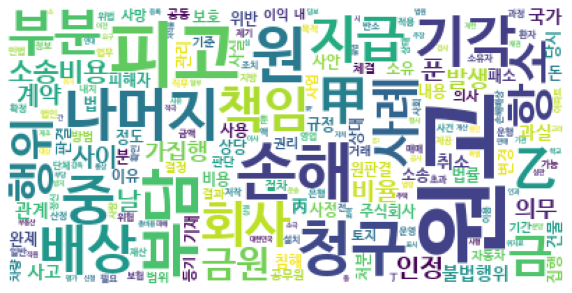

In [197]:
# wordcloud 패키지 다운로드
!pip install wordcloud
from wordcloud import WordCloud
wc = WordCloud(background_color="white", font_path='/Users/byeonghyeon/Documents/GitHub/IndustrialSystemsEngineering_Project/font/NanumBarunGothicBold.ttf')
wc.generate_from_frequencies(top_nouns)
# World
# 많이 나타나는 단어일수록 크게 나타남
import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(wc)

In [198]:
from konlpy.tag import Okt
okt = Okt()

oo = okt.pos(posts.iloc[0],
        norm=True,   # 정규화(normalization)
        stem=True    # 어간추출(stemming)
        )

print(oo)

[('甲', 'Foreign'), ('이', 'Noun'), ('배우자', 'Noun'), ('乙', 'Foreign'), ('의', 'Noun'), ('성', 'Modifier'), ('기능', 'Noun'), ('장애', 'Noun'), ('로', 'Josa'), ('인하다', 'Adjective'), ('사실혼', 'Noun'), ('관계', 'Noun'), ('가', 'Josa'), ('단기간', 'Noun'), ('에', 'Josa'), ('파탄', 'Noun'), ('되어다', 'Verb'), ('이유', 'Noun'), ('로', 'Josa'), ('乙', 'Foreign'), ('을', 'Josa'), ('상대로', 'Noun'), ('손해배상', 'Noun'), ('등', 'Noun'), ('을', 'Josa'), ('구한', 'Noun'), ('사안', 'Noun'), ('에서', 'Josa'), (',', 'Punctuation'), ('乙', 'Foreign'), ('은', 'Noun'), ('甲', 'Foreign'), ('에게', 'Josa'), ('위자료', 'Noun'), ('지급', 'Noun'), ('의무', 'Noun'), ('가', 'Josa'), ('있다', 'Adjective'), (',', 'Punctuation'), ('원상회복', 'Noun'), ('으로서', 'Josa'), ('甲', 'Foreign'), ('에게', 'Josa'), ('받다', 'Verb'), ('예물', 'Noun'), ('과', 'Josa'), ('점유', 'Noun'), ('중인', 'Noun'), ('혼수', 'Noun'), ('품', 'Noun'), ('등', 'Noun'), ('을', 'Josa'), ('인도', 'Noun'), ('하다', 'Verb'), ('의무', 'Noun'), ('가', 'Josa'), ('있다', 'Adjective'), ('하다', 'Verb'), ('사례', 'Noun'), ('甲', 'Foreign'),

In [199]:
# 첫번째 tokenizer(Okt)
def tokenizer_1(raw_texts, pos=["Noun","Alpha","Verb","Number"], stop_words=list(stop_words_df.get("불용어"))):
    p = okt.pos(raw_texts, 
            norm=True,   # 정규화(normalization)
            stem=True    # 어간추출(stemming)
            )
    o = [word for word, tag in p if len(word) > 1 and tag in pos and word[0] not in stop_words]
    return(o)

print(posts.iloc[-1])
print(tokenizer_1(posts.iloc[-1]))

甲 주식회사와 乙 주식회사가, 乙 회사의 무기물입자코팅(ceramic coating) 분리막에 관한 등록특허의 효력에 대한 소송계속 중 각자 제기한 소를 취하하기로 하면서 향후 등록특허와 관련하여 ‘국내/국외’에서 상호 쟁송을 제기하지 않는다’는 내용의 합의서를 작성하였는데, 乙 회사가 甲 회사 및 甲 회사의 미국법인 丙이 등록특허에 대응하는 乙 회사의 미국 특허 및 그 후속 특허를 침해하였다는 이유로 甲 회사 및 丙 법인을 상대로 미국무역위원회에 불공정무역행위조사신청을 제기하고 미국 델라웨어 연방지방법원에 특허권침해금지소송을 제기하자, 甲 회사 및 丙 법인이 乙 회사를 상대로 국내 법원에 위 합의상 부제소 의무 위반에 따른 손해배상 등을 구한 사안에서, 위 합의서 전문 및 본문의 문언 등에 비추어 위 합의의 대상은 등록특허로 한정된다고 보아야 하고 乙 회사가 미국 특허 및 그 후속 특허에 관한 부제소 의무까지 부담한다고 볼 수는 없다고 한 사례 甲 주식회사와 乙 주식회사가, 乙 회사의 무기물입자코팅(ceramic coating) 분리막에 관한 등록특허(이하 ‘대상특허’라 한다)의 효력에 대한 소송계속 중 각자 제기한 소를 취하하기로 하면서 향후 대상특허와 관련하여 ‘국내/국외’에서 상호 쟁송을 제기하지 않는다’는 내용의 합의서를 작성하였는데, 乙 회사가 甲 회사 및 甲 회사의 미국법인 丙이 대상특허에 대응하는 乙 회사의 미국 특허 및 그 후속 특허를 침해하였다는 이유로 甲 회사 및 丙 법인을 상대로 미국무역위원회에 불공정무역행위조사신청을 제기하고 미국 델라웨어 연방지방법원에 특허권침해금지소송을 제기하자, 甲 회사 및 丙 법인이 乙 회사를 상대로 국내 법원에 위 합의상 부제소 의무 위반에 따른 손해배상 등을 구한 사안이다.위 합의서 전문에서 합의의 대상이 되는 특허를 대상특허로 특정하고 있는 점, 위 합의서 본문 4항에서도 ‘대상특허와 관련’한 부제소 의무를 규정하고 있는 점 등에 비추어 볼 때 위 합의의 대상은 대상특허로 한정된다고 보아야 하고 乙 회사가 대

In [200]:
# 첫번째 tokenizer(Okt)
def tokenizer_3(raw_texts, pos=["Noun"], stop_words=list(stop_words_df.get("불용어"))):
    p = okt.pos(raw_texts, 
            norm=True,   # 정규화(normalization)
            stem=True    # 어간추출(stemming)
            )
    o = [word for word, tag in p if len(word) > 1 and tag in pos and word[0] not in stop_words]
    return(o)

print(posts.iloc[-1])
print(tokenizer_3(posts.iloc[-1]))

甲 주식회사와 乙 주식회사가, 乙 회사의 무기물입자코팅(ceramic coating) 분리막에 관한 등록특허의 효력에 대한 소송계속 중 각자 제기한 소를 취하하기로 하면서 향후 등록특허와 관련하여 ‘국내/국외’에서 상호 쟁송을 제기하지 않는다’는 내용의 합의서를 작성하였는데, 乙 회사가 甲 회사 및 甲 회사의 미국법인 丙이 등록특허에 대응하는 乙 회사의 미국 특허 및 그 후속 특허를 침해하였다는 이유로 甲 회사 및 丙 법인을 상대로 미국무역위원회에 불공정무역행위조사신청을 제기하고 미국 델라웨어 연방지방법원에 특허권침해금지소송을 제기하자, 甲 회사 및 丙 법인이 乙 회사를 상대로 국내 법원에 위 합의상 부제소 의무 위반에 따른 손해배상 등을 구한 사안에서, 위 합의서 전문 및 본문의 문언 등에 비추어 위 합의의 대상은 등록특허로 한정된다고 보아야 하고 乙 회사가 미국 특허 및 그 후속 특허에 관한 부제소 의무까지 부담한다고 볼 수는 없다고 한 사례 甲 주식회사와 乙 주식회사가, 乙 회사의 무기물입자코팅(ceramic coating) 분리막에 관한 등록특허(이하 ‘대상특허’라 한다)의 효력에 대한 소송계속 중 각자 제기한 소를 취하하기로 하면서 향후 대상특허와 관련하여 ‘국내/국외’에서 상호 쟁송을 제기하지 않는다’는 내용의 합의서를 작성하였는데, 乙 회사가 甲 회사 및 甲 회사의 미국법인 丙이 대상특허에 대응하는 乙 회사의 미국 특허 및 그 후속 특허를 침해하였다는 이유로 甲 회사 및 丙 법인을 상대로 미국무역위원회에 불공정무역행위조사신청을 제기하고 미국 델라웨어 연방지방법원에 특허권침해금지소송을 제기하자, 甲 회사 및 丙 법인이 乙 회사를 상대로 국내 법원에 위 합의상 부제소 의무 위반에 따른 손해배상 등을 구한 사안이다.위 합의서 전문에서 합의의 대상이 되는 특허를 대상특허로 특정하고 있는 점, 위 합의서 본문 4항에서도 ‘대상특허와 관련’한 부제소 의무를 규정하고 있는 점 등에 비추어 볼 때 위 합의의 대상은 대상특허로 한정된다고 보아야 하고 乙 회사가 대

In [201]:
# 두번째 tokenizer(mecab)
def tokenizer_2(raw_texts, pos=["Noun","Alpha","Verb","Number"], stop_words=list(stop_words_df.get("불용어"))):
    nouns = []
  
    for noun in tagger.nouns(raw_texts):
        if noun not in stop_words and len(noun)>1:
            nouns.append(noun)
    return nouns
print(posts.iloc[-1])
print(tokenizer_2(posts.iloc[-1]))

甲 주식회사와 乙 주식회사가, 乙 회사의 무기물입자코팅(ceramic coating) 분리막에 관한 등록특허의 효력에 대한 소송계속 중 각자 제기한 소를 취하하기로 하면서 향후 등록특허와 관련하여 ‘국내/국외’에서 상호 쟁송을 제기하지 않는다’는 내용의 합의서를 작성하였는데, 乙 회사가 甲 회사 및 甲 회사의 미국법인 丙이 등록특허에 대응하는 乙 회사의 미국 특허 및 그 후속 특허를 침해하였다는 이유로 甲 회사 및 丙 법인을 상대로 미국무역위원회에 불공정무역행위조사신청을 제기하고 미국 델라웨어 연방지방법원에 특허권침해금지소송을 제기하자, 甲 회사 및 丙 법인이 乙 회사를 상대로 국내 법원에 위 합의상 부제소 의무 위반에 따른 손해배상 등을 구한 사안에서, 위 합의서 전문 및 본문의 문언 등에 비추어 위 합의의 대상은 등록특허로 한정된다고 보아야 하고 乙 회사가 미국 특허 및 그 후속 특허에 관한 부제소 의무까지 부담한다고 볼 수는 없다고 한 사례 甲 주식회사와 乙 주식회사가, 乙 회사의 무기물입자코팅(ceramic coating) 분리막에 관한 등록특허(이하 ‘대상특허’라 한다)의 효력에 대한 소송계속 중 각자 제기한 소를 취하하기로 하면서 향후 대상특허와 관련하여 ‘국내/국외’에서 상호 쟁송을 제기하지 않는다’는 내용의 합의서를 작성하였는데, 乙 회사가 甲 회사 및 甲 회사의 미국법인 丙이 대상특허에 대응하는 乙 회사의 미국 특허 및 그 후속 특허를 침해하였다는 이유로 甲 회사 및 丙 법인을 상대로 미국무역위원회에 불공정무역행위조사신청을 제기하고 미국 델라웨어 연방지방법원에 특허권침해금지소송을 제기하자, 甲 회사 및 丙 법인이 乙 회사를 상대로 국내 법원에 위 합의상 부제소 의무 위반에 따른 손해배상 등을 구한 사안이다.위 합의서 전문에서 합의의 대상이 되는 특허를 대상특허로 특정하고 있는 점, 위 합의서 본문 4항에서도 ‘대상특허와 관련’한 부제소 의무를 규정하고 있는 점 등에 비추어 볼 때 위 합의의 대상은 대상특허로 한정된다고 보아야 하고 乙 회사가 대

In [202]:
vectorize = TfidfVectorizer(
    tokenizer = tokenizer_2, # 문장에 대한 tokenizer (위에 정의한 함수 이용)
    min_df = 10,            # 단어가 출현하는 최소 문서의 개수
    sublinear_tf = True,    # tf값에 1+log(tf)를 적용하여 tf값이 무한정 커지는 것을 막음
    stop_words = list(stop_words_df.get("불용어"))
)

X = vectorize.fit_transform(posts)
pd.DataFrame(X.toarray())

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['개의', '거니', '결과', '고려', '고용', '공동', '관계', '구체', '구토', '근거', '기관', '기점', '기준', '나다', '나머지', '노동', '노동부', '대로', '도착', '동시', '따름', '때문', '마음', '방면', '부령', '부류', '불문', '비교', '사람', '상대', '생각', '서술', '시작', '시초', '아래', '아무', '연관', '의거', '의지', '이외', '이용', '이유', '일반', '일지', '입각', '입장', '정도', '제외', '종합', '주저', '즈음', '지경', '진짜', '필요', '한적', '할만', '항목', '행정', '형식'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,0,1,2,3,4,5,6,7,8,9,...,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.179496,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823,0.0,0.110841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1824,0.0,0.049113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.055979,0.0,0.0,0.0
1825,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1826,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.093117,0.0,0.0,0.0


In [51]:
# pd.DataFrame(X.toarray()).to_excel("TF-IDF_Vectors.xlsx",index=False)

In [52]:
# vectorize = CountVectorizer(
# #     tokenizer=tokenizer, 
#     min_df=5    # 예제로 보기 좋게 1번 정도만 노출되는 단어들은 무시하기로 했다
#                 # min_df = 0.01 : 문서의 1% 미만으로 나타나는 단어 무시
#                 # min_df = 10 : 문서에 10개 미만으로 나타나는 단어 무시
#                 # max_df = 0.80 : 문서의 80% 이상에 나타나는 단어 무시
#                 # max_df = 10 : 10개 이상의 문서에 나타나는 단어 무시
# )
# X = vectorize.fit_transform(posts)
# # print('fit_transform, (sentence {}, feature {})'.format(X.shape[0], X.shape[1]))

# # 문장에서 뽑아낸 feature 들의 배열
# features = vectorize.get_feature_names()

# X.toarray()
# tf_idf_df = pd.DataFrame(X.toarray())
# tf_idf_df

In [203]:
tfidf_df = pd.DataFrame(X.toarray())
# tfidf_df = pd.read_excel("TF-IDF_vectors.xlsx")
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
# 2번째와 3번째 문서(유클리디안 거리 값)
print(euclidean_distances(X[1], X[2]))#, X)
# 2번째와 3번째 문서(코사인유사도 값)
print(cosine_similarity(X[1], X[0]))#, X)
# [[0.1837195]]

[[1.3794164]]
[[0.21386582]]


In [204]:
# target_id 와 유사한 판례를 cosine_similarity으로 계산하여 유사벡터 도출
# 약 1분 소요
cosine_result = {}
error_reslut = {}
target_id = 0
x = info_df[info_df['ID']==target_id].index[0]  # target_id의 Id값의 index

for y in range(len(info_df)):
    try:
        cosine_result[info_df['ID'].iloc[y]] = cosine_similarity(X[x], X[y])[0][0]
#         print(x,y,cosine_similarity(X[x], X[y]))
    except:
        error_reslut[info_df["ID"].iloc[y]] = cosine_similarity(X[x], X[y])
        print("error",x,y,cosine_similarity(X[x], X[y]))
sorted_cosine_dic = sorted(cosine_result.items(), key = lambda x:x[1], reverse = True)

# cosine_similariry 값 기준으로 내림차순 정렬된 유사 판례들
# 먼저나올수록 유사한 판례이다.
sorted_cosine_dic[0:11]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
id_list = [i[0] for i in sorted_cosine_dic[0:11]]
for i in sorted_cosine_dic[0:11]:
    for j in info_df[info_df["ID"]==i[0]]["참조조문"].iloc[0].split(","):
        print(j.strip())
    print("*"*10)

In [ ]:
cnt_기각 = 0
cnt_승소 = 0
cnt_일부승소 = 0
id_list = [i[0] for i in sorted_cosine_dic[1:11]]
for i in sorted_cosine_dic[1:11]:
    print(info_df[info_df["ID"]==i[0]]["주문"].iloc[0])
    if '나머지 청구를 기각한다' in info_df[info_df["ID"]==i[0]]["주문"].iloc[0] or "나머지 항소를 기각한다" in info_df[info_df["ID"]==i[0]]["주문"].iloc[0] or "나머지 청구" in info_df[info_df["ID"]==i[0]]["주문"].iloc[0] or "지급하라" in info_df[info_df["ID"]==i[0]]["주문"].iloc[0]:
        print("결과 : 일부승소")
        cnt_일부승소 += 1
    elif "기각" in info_df[info_df["ID"]==i[0]]["주문"].iloc[0]:
        print("결과 : 기각")
        cnt_기각 += 1
    else:
        print("결과 : 승소")
        cnt_승소 += 1
    print()

print("기각 :{}건\n승소 : {}건\n일부 승소 {}건".format(cnt_기각,cnt_승소,cnt_일부승소)) 


In [ ]:
# target_id 에 해당하는 판례와 유사한 판례 상위 10개 도출
for id_ in sorted_cosine_dic[0:11]:
    url = "http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID={}&type=XML".format(id_[0])
    url2 = "https://www.law.go.kr/precInfoP.do?mode=0&precSeq={}&vSct=*".format(id_[0])
    print(url2)

# TF-IDF Vectorizer (tokenizer_2)

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorize = TfidfVectorizer(
    tokenizer = tokenizer_2, # 문장에 대한 tokenizer (위에 정의한 함수 이용)
    min_df = 10,            # 단어가 출현하는 최소 문서의 개수
    sublinear_tf = True,    # tf값에 1+log(tf)를 적용하여 tf값이 무한정 커지는 것을 막음
    stop_words = list(stop_words_df.get("불용어"))
)

X2 = vectorize.fit_transform(posts)
pd.DataFrame(X2.toarray())

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['개의', '거니', '결과', '고려', '고용', '공동', '관계', '구체', '구토', '근거', '기관', '기점', '기준', '나다', '나머지', '노동', '노동부', '대로', '도착', '동시', '따름', '때문', '마음', '방면', '부령', '부류', '불문', '비교', '사람', '상대', '생각', '서술', '시작', '시초', '아래', '아무', '연관', '의거', '의지', '이외', '이용', '이유', '일반', '일지', '입각', '입장', '정도', '제외', '종합', '주저', '즈음', '지경', '진짜', '필요', '한적', '할만', '항목', '행정', '형식'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,0,1,2,3,4,5,6,7,8,9,...,681,682,683,684,685,686,687,688,689,690
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.292341,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [59]:
tfidf2_df = pd.DataFrame(X2.toarray())
# tfidf_df = pd.read_excel("TF-IDF_vectors.xlsx")

In [61]:
# target_id 와 유사한 판례를 cosine_similarity으로 계산하여 유사벡터 도출
# 약 1분 소요
cosine_result = {}
error_reslut = {}
target_id = 208911
x = info_df[info_df['ID']==target_id].index[0]  # target_id의 Id값의 index

for y in range(len(info_df)):
    try:
        cosine_result[info_df['ID'].iloc[y]] = cosine_similarity(X2[x], X2[y])[0][0]
#         print(x,y,cosine_similarity(X[x], X[y]))
    except:
        error_reslut[info_df["ID"].iloc[y]] = cosine_similarity(X2[x], X2[y])
        print("error",x,y,cosine_similarity(X2[x], X2[y]))
sorted_cosine_dic = sorted(cosine_result.items(), key = lambda x:x[1], reverse = True)

# cosine_similariry 값 기준으로 내림차순 정렬된 유사 판례들
# 먼저나올수록 유사한 판례이다.
sorted_cosine_dic 

[(120133, 1.0000000000000002),
 (129739, 0.37256836400600385),
 (120464, 0.37256836400600385),
 (212507, 0.328236921610331),
 (70246, 0.28117119015268655),
 (209921, 0.2762261260762003),
 (71996, 0.2638279577634479),
 (118606, 0.2423036204095516),
 (72187, 0.22113891122101273),
 (73774, 0.2197174694847632),
 (119878, 0.2151113561421116),
 (72819, 0.21350012995654516),
 (75417, 0.21092495458558447),
 (70203, 0.21043006718472232),
 (118426, 0.206269842966958),
 (75136, 0.2059731191005069),
 (76169, 0.20447559543832305),
 (73692, 0.20343987762727006),
 (118534, 0.1937332116490188),
 (76739, 0.1936318173887942),
 (73500, 0.19285311189254709),
 (69839, 0.1922181287348894),
 (72149, 0.18178746394506204),
 (71387, 0.18061386390133538),
 (140825, 0.17870098850907876),
 (71623, 0.1780455777370669),
 (73467, 0.17562091869861585),
 (145789, 0.17339294456089746),
 (76600, 0.1729371467207863),
 (73740, 0.17276805698193465),
 (212161, 0.17059039562602757),
 (212347, 0.16877331641815263),
 (118944, 0

In [62]:
# target_id 에 해당하는 판례와 유사한 판례 상위 10개 도출
for id_ in sorted_cosine_dic[0:11]:
    url = "http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID={}&type=XML".format(id_[0])
    url2 = "https://www.law.go.kr/precInfoP.do?mode=0&precSeq={}&vSct=*".format(id_[0])
    print(url)

http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=120133&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=129739&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=120464&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=212507&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=70246&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=209921&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=71996&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=118606&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=72187&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=73774&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=119878&type=XML


# DBSCAN Clustering

1.2904866411151878


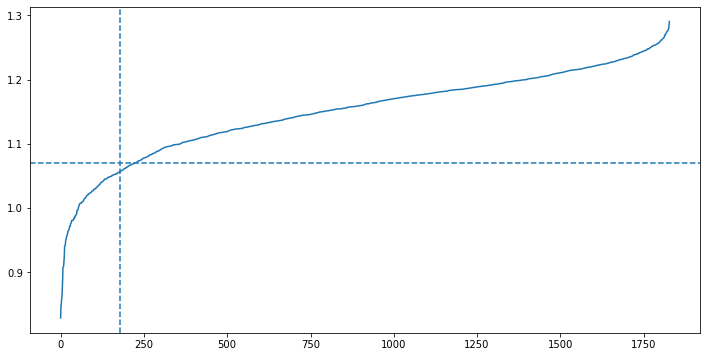

In [214]:
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X)
distances, indices = neigh.kneighbors(X)
plt.figure(figsize=(12, 6))
plt.plot(np.sort(distances[:, 4]))
plt.axvline(178, 0, 2, ls='--')
plt.axhline(1.07, 0, 200, ls='--')
print(np.sort(distances[:, 4])[1827])

In [215]:
# dbscan = DBSCAN(eps = 0.5, min_samples=5)
ss = StandardScaler()
scaled_df = pd.DataFrame(ss.fit_transform(tfidf_df))
dbscan = DBSCAN(eps = 0.1)
dbscan_cluster = dbscan.fit_predict(scaled_df)
dbscan_cluster

array([-1, -1, -1, ..., -1, -1, -1])

In [216]:
# 군집화 된 패키지들을 DataFrame에 잘 들어가도록 전처리

dbscan_clustered_dic = {}
dbscan_clustered_list = []
dbscan_cluster_num = len(set(dbscan_cluster))
for idx,i in enumerate(dbscan_cluster):
    if i not in dbscan_clustered_dic:
        dbscan_clustered_dic[i] = [info_df['ID'].iloc[idx]]
    else:
        dbscan_clustered_dic[i].append(info_df['ID'].iloc[idx])
dbscan_clustered_dic
# 클러스터링이 된 패키지들
# 20개의 군집으로 생성

dbscan_clustered_dic = sorted(dbscan_clustered_dic.items(), key=lambda x: x[0])
dbscan_clustered_dic

[(-1,
  [165171,
   167374,
   74874,
   74855,
   75007,
   71848,
   71846,
   120823,
   120176,
   133481,
   71164,
   192385,
   118780,
   70572,
   118303,
   119193,
   118253,
   118538,
   119274,
   119294,
   119276,
   118460,
   184658,
   65017,
   118611,
   118444,
   118853,
   118686,
   71871,
   212425,
   208477,
   159788,
   138226,
   76752,
   140320,
   205652,
   177819,
   72156,
   146042,
   77021,
   76919,
   76837,
   76831,
   76760,
   76756,
   146045,
   77025,
   77024,
   76834,
   76833,
   76827,
   76826,
   76822,
   146013,
   76879,
   76859,
   76778,
   76678,
   118851,
   146034,
   76954,
   73539,
   75804,
   120531,
   214537,
   74659,
   176571,
   176463,
   142045,
   72644,
   72154,
   138188,
   129754,
   76131,
   75945,
   75940,
   75834,
   75609,
   75601,
   75571,
   75560,
   75535,
   75531,
   75522,
   75411,
   75410,
   75398,
   75387,
   75190,
   75183,
   75175,
   75148,
   75107,
   74917,
   74609,
   74

In [217]:
df_dbscan_cluster = pd.DataFrame(dbscan_clustered_dic,columns=['num','clusters'])
dbscan_cluster_num = [len(i) for i in df_dbscan_cluster['clusters']]
df_dbscan_cluster['cluster_num'] = dbscan_cluster_num
df_dbscan_cluster

,num,clusters,cluster_num
0,-1,"[165171, 167374, 74874, 74855, 75007, 71848, 7...",1828


# Kmeans

In [218]:
# Instantiate the clustering model 
# n_init : 랜덤한 초기값을 몇번이나 다르게 설정해서 돌릴건지
# max_iter=300 : iteration을 반복적으로 수행하면 서 좋을 결과로 수렴하게되는데 그 횟수를 몇번 할 것인지
# verbose : 계산과정 보여줌 0,1,2 이렇게 해서 보여주는 정보의 양을 조절 할 수있음

# 15개의 클러스터를 만들기 
n_clusters = 18
kmeans = KMeans(n_clusters=n_clusters)
# kmeans = KMeans(n_clusters=4,verbose = 1)
kmeans

KMeans(n_clusters=18)

In [219]:
# 모델에 fitting 하기
kmeans.fit(scaled_df)

y_kmeans = kmeans.predict(scaled_df)
y_kmeans[0:10] # 군집화 된 결과


array([12, 14,  4,  6,  4,  6,  6,  6,  6,  6], dtype=int32)

In [220]:
# 군집의 중심
kmeans.cluster_centers_

array([[-0.15466156,  0.10480124, -0.1115236 , ..., -0.09800255,
         2.54018765, -0.17909938],
       [-0.15466156,  0.72885297,  0.00903782, ...,  0.42294493,
        -0.09480228, -0.17909938],
       [-0.15466156,  1.42227916, -0.1115236 , ..., -0.09800255,
        -0.09480228, -0.17909938],
       ...,
       [-0.15466156, -0.02807438, -0.1115236 , ..., -0.09800255,
        -0.09480228, -0.17909938],
       [-0.15466156,  1.54030708, -0.1115236 , ..., -0.09800255,
        -0.09480228, -0.17909938],
       [-0.15466156, -0.13685265,  0.02240222, ..., -0.01550815,
        -0.01584863, -0.17909938]])

In [221]:
kmeans.labels_[0:8]

array([12, 14,  4,  6,  4,  6,  6,  6], dtype=int32)

In [222]:
# 클러스터링의 성능측정
# 값이 높을 수록 좋음
kmeans.inertia_

2393154.2093789643

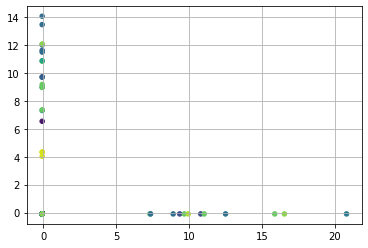

In [223]:
plt.scatter(np.array(scaled_df)[:,3], np.array(scaled_df)[:,4], c=y_kmeans, s=20, cmap='viridis')

centers = kmeans.cluster_centers_
# plt.scatter(centers[:,0], centers[:,1], c='black', s=100, alpha=0.5)
plt.grid()
plt.show()

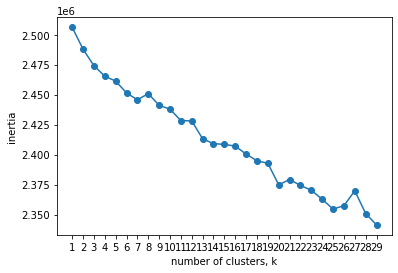

In [224]:
ks = range(1,30)

inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(scaled_df)
    inertias.append(model.inertia_)
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


In [225]:
# 군집화 된 패키지들을 DataFrame에 잘 들어가도록 전처리

clustered_dic = {}
clustered_list = []
cluster_num = len(set(y_kmeans))
for idx,i in enumerate(y_kmeans):
    if i not in clustered_dic:
        clustered_dic[i] = [info_df['ID'].iloc[idx]]
    else:
        clustered_dic[i].append(info_df['ID'].iloc[idx])
clustered_dic
# 클러스터링이 된 패키지들
# 20개의 군집으로 생성

clustered_dic = sorted(clustered_dic.items(), key=lambda x: x[0])
clustered_dic

[(0,
  [74623,
   72383,
   72374,
   71898,
   72453,
   70565,
   166225,
   130660,
   177956,
   120070,
   118542,
   160216,
   119534,
   120592,
   119356,
   118609,
   193358,
   144367,
   140317,
   212205,
   120139,
   119877,
   211833,
   70637,
   179085,
   71053,
   70355,
   77045,
   118683,
   118695,
   76942,
   76883,
   120052]),
 (1,
  [118611,
   159788,
   75107,
   75516,
   74624,
   72052,
   152078,
   76508,
   76396,
   75847,
   75559,
   75145,
   74511,
   73946,
   73328,
   72306,
   76340,
   76253,
   76157,
   212127,
   119443,
   120048,
   119875,
   141543,
   140845,
   164800,
   70423,
   120250,
   118939,
   166431,
   161854,
   157550,
   149295,
   138569,
   70731,
   209329,
   172671,
   125072,
   119532,
   119533,
   119272,
   70453,
   70630,
   194196,
   136168,
   70506,
   70455,
   120834,
   120829,
   119873,
   119707,
   119704,
   212367,
   64821,
   184151,
   70592,
   212433,
   120837,
   160657,
   160202,
 

In [226]:
df_cluster = pd.DataFrame(clustered_dic,columns=['num','clusters'])
cluster_num = [len(i) for i in df_cluster['clusters']]
df_cluster['cluster_num'] = cluster_num
df_cluster

,num,clusters,cluster_num
0,0,"[74623, 72383, 72374, 71898, 72453, 70565, 166...",33
1,1,"[118611, 159788, 75107, 75516, 74624, 72052, 1...",80
2,2,"[129750, 207124, 70936, 214469, 178674, 65016,...",7
3,3,"[76646, 75173, 74698, 76769, 75658, 118792, 11...",35
4,4,"[74874, 75007, 75410, 73793, 74619, 72243, 721...",68
5,5,"[76131, 72683, 72142, 74075, 72248, 76497, 761...",36
6,6,"[74855, 71848, 71846, 120823, 120176, 133481, ...",660
7,7,"[77021, 75560, 73945, 74843, 75728, 75422, 752...",38
8,8,"[119193, 118253, 77024, 76822, 76859, 76778, 7...",19
9,9,"[73221, 120251, 119945, 77042]",4


# T-SNE

In [227]:
m = TSNE(learning_rate = 50)
tsne_features = m.fit_transform(pd.DataFrame(X.toarray()))
tsne_features

array([[-22.121632, -42.358418],
       [ -9.17344 ,  17.37593 ],
       [ -7.987824, -41.63831 ],
       ...,
       [ 11.441946, -42.159714],
       [-24.48017 ,  41.763554],
       [-30.592607,  40.763504]], dtype=float32)

In [228]:
df = pd.DataFrame()
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]

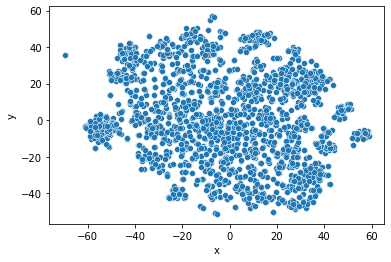

In [229]:
sns.scatterplot(x="x",y="y",data = df)
plt.show()

In [230]:
tsne_features

array([[-22.121632, -42.358418],
       [ -9.17344 ,  17.37593 ],
       [ -7.987824, -41.63831 ],
       ...,
       [ 11.441946, -42.159714],
       [-24.48017 ,  41.763554],
       [-30.592607,  40.763504]], dtype=float32)

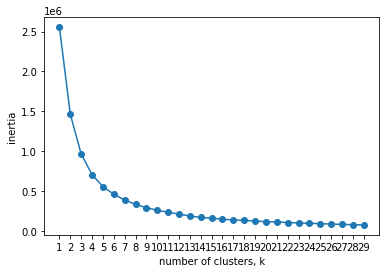

In [231]:
ks = range(1,30)

inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(tsne_features)
    inertias.append(model.inertia_)
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


In [238]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters)
# kmeans = KMeans(n_clusters=4,verbose = 1)
kmeans

# 모델에 fitting 하기
kmeans.fit(tsne_features)

y_kmeans = kmeans.predict(tsne_features)
y_kmeans[0:10] # 군집화 된 결과


array([5, 2, 5, 5, 5, 1, 5, 3, 4, 2], dtype=int32)

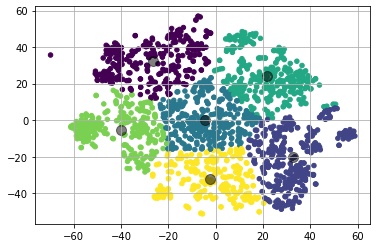

In [239]:
plt.scatter(np.array(tsne_features)[:,0], np.array(tsne_features)[:,1], c=y_kmeans, s=20, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=100, alpha=0.5)
plt.grid()
plt.show()

In [240]:
# 군집화 된 패키지들을 DataFrame에 잘 들어가도록 전처리

clustered_dic = {}
clustered_list = []
cluster_num = len(set(y_kmeans))
for idx,i in enumerate(y_kmeans):
    if i not in clustered_dic:
        clustered_dic[i] = [info_df['ID'].iloc[idx]]
    else:
        clustered_dic[i].append(info_df['ID'].iloc[idx])
clustered_dic
# 클러스터링이 된 패키지들
# 20개의 군집으로 생성

clustered_dic = sorted(clustered_dic.items(), key=lambda x: x[0])
clustered_dic

[(0,
  [192385,
   70572,
   65017,
   118853,
   212425,
   208477,
   140320,
   177819,
   75804,
   214537,
   138188,
   129754,
   76735,
   75518,
   75005,
   74978,
   72085,
   77058,
   77055,
   76929,
   76502,
   76239,
   75939,
   75517,
   75162,
   74892,
   74878,
   74869,
   74499,
   73730,
   73183,
   72690,
   72542,
   72012,
   76154,
   75743,
   75726,
   76336,
   75770,
   72831,
   70536,
   70353,
   120278,
   119297,
   119721,
   145878,
   119133,
   118962,
   125202,
   70565,
   70563,
   70457,
   129677,
   158500,
   210941,
   205654,
   205636,
   214711,
   206200,
   164922,
   138184,
   158873,
   136180,
   214527,
   215445,
   143475,
   135880,
   168211,
   71106,
   172357,
   168293,
   145787,
   139110,
   138584,
   158784,
   118457,
   170914,
   77023,
   70349,
   175316,
   170871,
   149860,
   182936,
   166454,
   70990,
   76194,
   211637,
   205607,
   144816,
   205616,
   212135,
   148922,
   120853,
   118443,
  

In [241]:
df_cluster = pd.DataFrame(clustered_dic,columns=['num','clusters'])
cluster_num = [len(i) for i in df_cluster['clusters']]
df_cluster['cluster_num'] = cluster_num
df_cluster

,num,clusters,cluster_num
0,0,"[192385, 70572, 65017, 118853, 212425, 208477,...",308
1,1,"[71848, 118686, 71871, 72156, 73539, 76131, 75...",340
2,2,"[167374, 133481, 71164, 118780, 118303, 119193...",332
3,3,"[120823, 118460, 77021, 76919, 76837, 76831, 7...",323
4,4,"[120176, 184658, 118611, 159788, 205652, 14601...",265
5,5,"[165171, 74874, 74855, 75007, 71846, 119294, 1...",260


In [242]:
nouns_entire = []
for i in df_cluster["clusters"]:
    nouns_temp = []
    for j in i:
        for noun in tagger.nouns(info_df[info_df["ID"] == j]["이유"].iloc[0]):
            if noun not in list(stop_words_df.get("불용어")):
                nouns_temp.append(noun) 
    nouns_entire.append(nouns_temp)

{'원고': 1277, '회사': 1215, '甲': 945, '손해': 865, '乙': 792, '행위': 687, '피고': 630, '사례': 558, '배상': 527, '청구': 511, '책임': 491, '부담': 470, '중': 464, '원': 459, '주식회사': 440, '침해': 431, '나머지': 397, '지급': 378, '丙': 357, '인정': 357, '기각': 332, '사용': 324, '날': 322, '부분': 304, '내용': 303, '저작': 298, '계약': 291, '의무': 285, '사안': 281, '사이': 278, '불법행위': 266, '정보': 261, '거래': 244, '보호': 237, '발생': 232, '소송비용': 230, '비율': 220, '저작물': 211, '관계': 204, '제공': 204, '영업': 203, '이유': 201, '사실': 200, '법률': 191, '서비스': 188, '판매': 187, '금원': 187, '이사': 184, '상대': 183, '규정': 182, '제조': 176, '가집행': 173, '법': 173, '위반': 167, '명예': 165, '丁': 163, '이용': 163, '항소': 161, '이익': 161, '사정': 159, '법인': 155, '상당': 152, '투자': 149, '주식': 149, '기재': 148, '표현': 148, '피해자': 147, '기사': 140, '권리': 138, '판단': 136, '훼손': 136, '정도': 136, '제품': 134, '대상': 134, '방법': 134, '업무': 133, '체결': 132, '금': 130, '액': 130, '보도': 127, '증권': 127, '기준': 124, '평가': 124, '재산': 123, '국가': 123, '돈': 122, '상품': 121, '사건': 121, '금융': 121, '사진': 121, '사회': 1

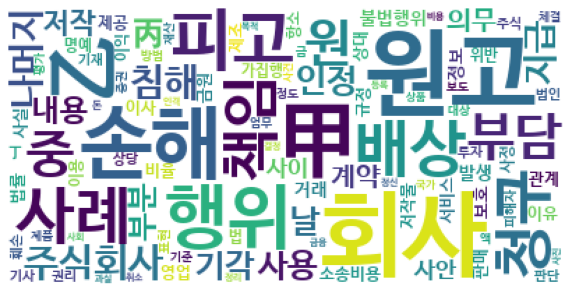

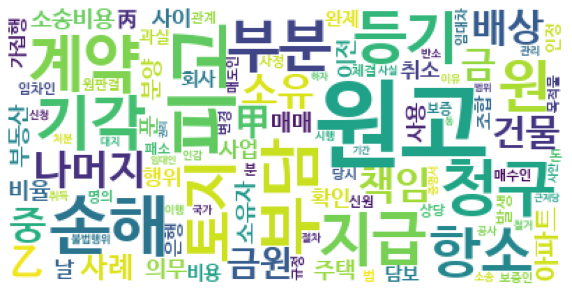

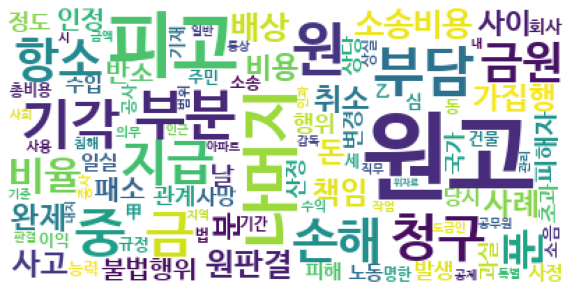

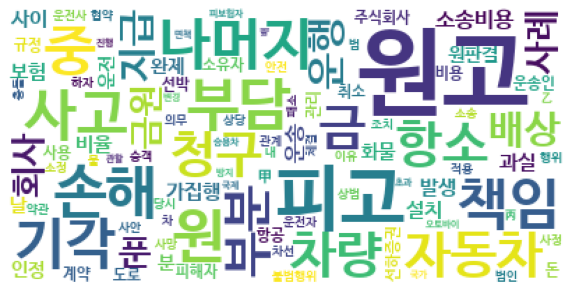

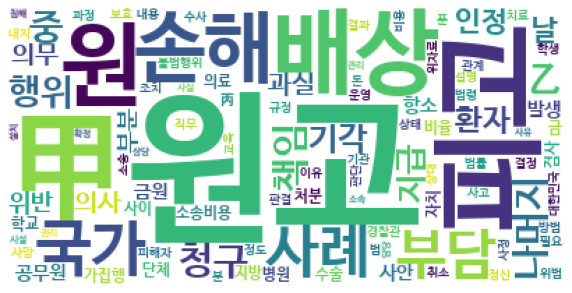

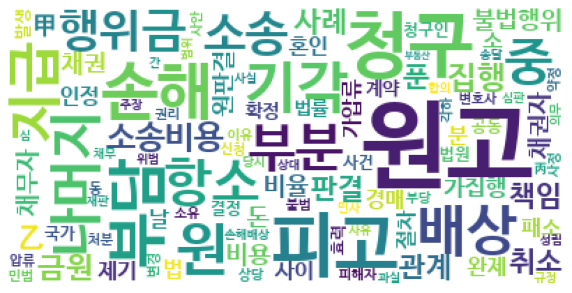

In [243]:
for idx,nouns in enumerate(nouns_entire):
    num_top_nouns = 100
    nouns_counter = Counter(nouns)
    top_nouns = dict(nouns_counter.most_common(num_top_nouns)[0:])
#     print(top_nouns)
    wc = WordCloud(background_color="white", font_path='/Users/byeonghyeon/Documents/GitHub/IndustrialSystemsEngineering_Project/font/NanumBarunGothicBold.ttf')
    wc.generate_from_frequencies(top_nouns)
    # World
    # 많이 나타나는 단어일수록 크게 나타남
    figure = plt.figure()
    figure.set_size_inches(10, 10)
    ax = figure.add_subplot(1, 1, 1)
    ax.axis("off")
    ax.imshow(wc)
    plt.savefig('{}cluster.png'.format(idx+1))
    print(dict(nouns_counter.most_common(num_top_nouns)[0:100]))

In [82]:
df_cluster.to_excel("K-Means_clusters.xlsx",index=False)

In [248]:
for i in df_cluster.iloc[1]["clusters"]:
    url2 = "https://www.law.go.kr/precInfoP.do?mode=0&precSeq={}&vSct=*".format(i)
    print(url2)

https://www.law.go.kr/precInfoP.do?mode=0&precSeq=71848&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=118686&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=71871&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=72156&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=73539&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=76131&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=75945&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=75531&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=75522&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=75411&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=75398&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=74609&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=73520&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=72683&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=72666&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=7230

In [249]:
# 부동산 cluster
부동산_ser = df_cluster.iloc[1]
for i in 부동산_ser["clusters"]:
    url2 = "https://www.law.go.kr/precInfoP.do?mode=0&precSeq={}&vSct=*".format(i)
#     print(url2)
    print(i)

71848
118686
71871
72156
73539
76131
75945
75531
75522
75411
75398
74609
73520
72683
72666
72305
72142
72093
76920
76746
76648
76308
76223
75610
75598
75564
75197
74919
74913
74877
74665
74648
74451
74075
74033
73999
73935
73773
73720
73712
73544
73535
73492
73480
73334
73317
73279
73232
73221
73089
73085
73076
72787
72473
72398
72371
72175
71812
77049
76966
75756
75667
76823
76754
76520
76503
76497
76496
76488
76398
76238
76237
76128
76045
75944
75603
75593
75574
75540
75427
75381
75151
75139
74909
74872
74944
74933
74674
74644
74625
74621
74524
74504
74500
74487
74484
74338
74337
74320
74305
74298
74286
74285
74229
74120
74099
74085
74067
74065
74066
74057
74032
74020
74002
73993
73983
73958
73959
73791
73768
73737
73710
73564
73545
73530
73441
73439
73333
73325
73265
73255
73240
73088
73072
73048
73044
73017
73004
73003
72974
152009
72837
72829
72816
72807
72799
72753
72754
72676
152051
72612
72503
72500
72480
72465
72392
72378
72369
72366
72357
72350
72337
72312
72227
71997
71989
7

In [260]:
info_df[info_df["ID"] ==119524]

,ID,참조조문,주문,이유
1830,119524,"민법 제393조, \n\n 제763조, \n\n 제751조",1. 원심판결의 피고 1에 대한 부분 중 아래에서 지급을 명하는 부분에 해당하...,임대인이 요구하면 건물을 철거하기로 약정한 임차인이 건물철거요구에 응하지 아니함으로...


# 다중 클러스터링

In [263]:
부동산_df = pd.DataFrame()
for i in 부동산_ser["clusters"]:
    부동산_df = 부동산_df.append(info_df[info_df["ID"]==i])
부동산_df.to_excel("부동산.xlsx",index = False)
부동산_df

,ID,참조조문,주문,이유
5,71848,민법 제245조,원판결을 취소한다. 피고는 원고에 대하여 김제군 죽산면 죽산리 708번지의 23 ...,하천부지 시효취득의 가부 하천부지는 그 공용성이 폐지된 이후가 아니면 취득시효의 목...
28,118686,"민법 제212조, \n\n 제214조, \n\n 제750조",1. 원판결 중 아래에서 지급을 명하는 원고들 패소부분을 취소한다. 피고들은 ...,건물신축을 목적으로 자기소유의 대지에 굴착공사를 함으로써 그와 인접한 대지가 우뚝 ...
30,71871,징발에관한특별조치령 제2조,"원판결을 취소한다. 원고의 청구는 이를 기각한다. 소송비용은 1,2심 공히 원고의...",징발목적물 소유자가 국가에 대해 불법점거를 전제로 손해배상 등을 청구할 수 있는지 ...
41,72156,민법 제105조,"원판결은 다음과 같이 변경한다. 피고는 원고에게 돈 14,490원을 지급하라. 원...",김해읍의 재정이 허락되면 그 당시의 싯가에 쫓아 보상하여 주기로 약정한 경우 그 보...
65,73539,"민법 제763조\n, \n 제396조",원판결중 반소에 대한 부분을 다음과 같이 변경한다. 반소피고는 반소원고에게 돈 1...,부동산을 담보로 돈을 대여할 경우 채권자가 조사확인할 주의의무의 정도 일반적으로 부...
...,...,...,...,...
1879,145761,"공인중개사의 업무 및 부동산 거래신고에 관한 법률 제25조 제1항, \n ...","1. 제1심판결 중 49,730,093원과 이에 대하여 2009. 6. 25.부...",공인중개사가 아파트 임대차계약을 중개하면서 등기부상 아파트의 표제부 중 ‘대지권의 ...
1955,73698,"중앙도매시장법 제3조\n, \n 제5조\n, \n 제6조의...",원고의 항소 및 당심에서의 확장청구 및 예비적 청구를 모두 기각한다. 항소비용 및...,중앙도매시장 업무대행권의 재위임계약이 무효인지의 여부와 그 계약위반으로 인한 손해배...
1962,74272,"민법 제750조\n, \n 토지구획정리사업법 제52조\n, \n ...",1. 원판결을 다음과 같이 변경한다. 피고(반소원고)는 원고(반소피고)에게 돈...,토지구획정리사업 시행 이전부터 도로에 공한 토지에 대하여 환지의 지정되 아니하고 ...
1964,76017,"토지수용법 제28조, \n 토지수용법 제35조, \n 구 ...",피고가 1982. 7. 28. 원고들의 별지목록기재 토지에 대한 손실보상재결 신청을...,1. 서울특별시장이 행하는 하천제방축조공사에 따른 손실보상의 관할토지수용위원회2. ...


In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorize = TfidfVectorizer(
    tokenizer = tokenizer_2, # 문장에 대한 tokenizer (위에 정의한 함수 이용)
    min_df = 10,            # 단어가 출현하는 최소 문서의 개수
    sublinear_tf = True,    # tf값에 1+log(tf)를 적용하여 tf값이 무한정 커지는 것을 막음
    stop_words = list(stop_words_df.get("불용어"))
)

X3 = vectorize.fit_transform(부동산_df.get("이유"))
pd.DataFrame(X3.toarray())


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['개의', '거니', '결과', '고려', '고용', '공동', '관계', '구체', '구토', '근거', '기관', '기점', '기준', '나다', '나머지', '노동', '노동부', '대로', '도착', '동시', '따름', '때문', '마음', '방면', '부령', '부류', '불문', '비교', '사람', '상대', '생각', '서술', '시작', '시초', '아래', '아무', '연관', '의거', '의지', '이외', '이용', '이유', '일반', '일지', '입각', '입장', '정도', '제외', '종합', '주저', '즈음', '지경', '진짜', '필요', '한적', '할만', '항목', '행정', '형식'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,0,1,2,3,4,5,6,7,8,9,...,223,224,225,226,227,228,229,230,231,232
0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.306538,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.211986,0.0,0.000000,0.200938,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.265354,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.0,0.0,0.105582,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.135924,0.0,0.000000,0.0,0.0,0.0
252,0.0,0.0,0.105575,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.230123,0.0,0.000000,0.0,0.0,0.0
253,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.146903,0.0,...,0.0,0.0,0.0,0.0,0.199824,0.0,0.000000,0.0,0.0,0.0
254,0.0,0.0,0.082008,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.366003,0.0,0.0,0.0


In [129]:
m = TSNE(learning_rate = 50)
tsne_features = m.fit_transform(pd.DataFrame(X3.toarray()))
df = pd.DataFrame()
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]

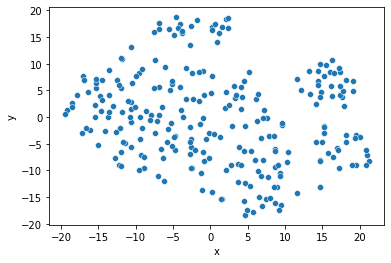

In [130]:
sns.scatterplot(x="x",y="y",data = df)
plt.show()

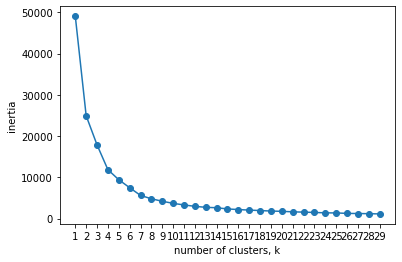

In [131]:
ks = range(1,30)

inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(tsne_features)
    inertias.append(model.inertia_)
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


In [132]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters)
# kmeans = KMeans(n_clusters=4,verbose = 1)
kmeans

# 모델에 fitting 하기
kmeans.fit(tsne_features)

y_kmeans = kmeans.predict(tsne_features)
y_kmeans[0:10] # 군집화 된 결과


array([4, 1, 2, 1, 0, 1, 1, 2, 3, 3], dtype=int32)

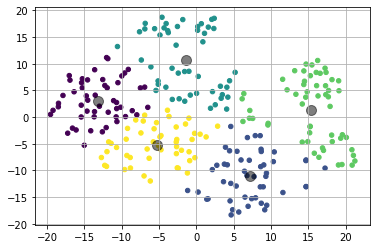

In [133]:
plt.scatter(np.array(tsne_features)[:,0], np.array(tsne_features)[:,1], c=y_kmeans, s=20, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=100, alpha=0.5)
plt.grid()
plt.show()

In [134]:
# 군집화 된 패키지들을 DataFrame에 잘 들어가도록 전처리

부동산_clustered_dic = {}
부동산_clustered_list = []
부동산_cluster_num = len(set(y_kmeans))
for idx,i in enumerate(y_kmeans):
    if i not in 부동산_clustered_dic:
        부동산_clustered_dic[i] = [부동산_df['ID'].iloc[idx]]
    else:
        부동산_clustered_dic[i].append(부동산_df['ID'].iloc[idx])
부동산_clustered_dic
# 클러스터링이 된 패키지들
# 20개의 군집으로 생성

부동산_clustered_dic = sorted(부동산_clustered_dic.items(), key=lambda x: x[0])
부동산_clustered_dic

[(0,
  [75522.0,
   76746.0,
   75610.0,
   74919.0,
   74877.0,
   74665.0,
   74648.0,
   73089.0,
   77049.0,
   76496.0,
   76237.0,
   75151.0,
   74909.0,
   74876.0,
   74487.0,
   74442.0,
   74020.0,
   73768.0,
   73441.0,
   73325.0,
   73322.0,
   73265.0,
   73255.0,
   73004.0,
   72974.0,
   152009.0,
   72837.0,
   72753.0,
   72754.0,
   72609.0,
   72350.0,
   72337.0,
   72312.0,
   71906.0,
   76941.0,
   76604.0,
   76820.0,
   70390.0,
   74498.0,
   210289.0,
   119520.0,
   118631.0,
   118247.0,
   139105.0,
   119699.0,
   70893.0,
   119212.0,
   118435.0,
   118290.0,
   120244.0,
   145969.0]),
 (1,
  [73539.0,
   75945.0,
   75411.0,
   75398.0,
   72666.0,
   75598.0,
   73773.0,
   73480.0,
   72473.0,
   72398.0,
   76238.0,
   74504.0,
   74500.0,
   74120.0,
   74099.0,
   73993.0,
   73282.0,
   73048.0,
   73044.0,
   71998.0,
   75668.0,
   76166.0,
   75976.0,
   170892.0,
   158761.0,
   120998.0,
   167632.0,
   166175.0,
   118541.0,
   70707.0

In [135]:
부동산_df_cluster = pd.DataFrame(부동산_clustered_dic,columns=['num','clusters'])
부동산_cluster_num = [len(i) for i in 부동산_df_cluster['clusters']]
부동산_df_cluster['cluster_num'] = 부동산_cluster_num
부동산_df_cluster

,num,clusters,cluster_num
0,0,"[75522.0, 76746.0, 75610.0, 74919.0, 74877.0, ...",51
1,1,"[73539.0, 75945.0, 75411.0, 75398.0, 72666.0, ...",50
2,2,"[76131.0, 74917.0, 72683.0, 72142.0, 74075.0, ...",50
3,3,"[74518.0, 73702.0, 73015.0, 72093.0, 74104.0, ...",56
4,4,"[71871.0, 73520.0, 71963.0, 71968.0, 74913.0, ...",49


In [136]:
부동산_nouns_entire = []
for i in 부동산_df_cluster["clusters"]:
    nouns_temp = []
    for j in i:
        for noun in tagger.nouns(부동산_df[부동산_df["ID"] == j]["이유"].iloc[0]):
            if noun not in list(stop_words_df.get("불용어")):
                nouns_temp.append(noun) 
    부동산_nouns_entire.append(nouns_temp)


{'계약': 164, '매매': 146, '원고': 136, '피고': 96, '매수인': 93, '청구': 82, '매도인': 80, '기각': 64, '지급': 63, '부담': 61, '손해': 60, '항소': 58, '원': 52, '나머지': 46, '금': 45, '배상': 44, '부분': 43, '해제': 42, '중': 40, '토지': 38, '소유': 38, '소송비용': 38, '권리': 38, '금원': 38, '푼': 36, '책임': 35, '목적물': 33, '이전': 30, '취소': 29, '완제': 28, '비율': 28, '원판결': 26, '당사자': 25, '사례': 24, '체결': 24, '분': 23, '이행': 23, '비용': 23, '등기': 22, '의무': 22, '변경': 21, '부동산': 21, '사이': 21, '매수': 20, '패소': 19, '당시': 19, '대금': 18, '의사': 18, '범위': 18, '가집행': 17, '대지': 16, '취득': 16, '행불': 16, '상당': 16, '반소': 16, '담보': 15, '표시': 15, '관계': 15, '민법': 14, '거래': 14, '사유': 14, '계약금': 14, '착오': 13, '일부': 12, '행위': 12, '재산': 12, '이유': 12, '소송': 12, '이익': 12, '목적': 12, '갑': 12, '공유자': 12, '행사': 11, '시': 11, '성질': 10, '약정': 10, '하자': 10, '불능': 10, '상실': 10, '기간': 9, '싯': 9, '성립': 9, '기본': 9, '건축': 9, '지분': 9, '사실': 8, '소': 8, '소유자': 8, '과실': 8, '발생': 8, '능': 8, '주문': 8, '산정': 8, '판단': 8, '기초': 8, '매도': 8, '물품': 8, '날': 8, '폐기물': 8, '초과': 7}
{'계약': 164, '매

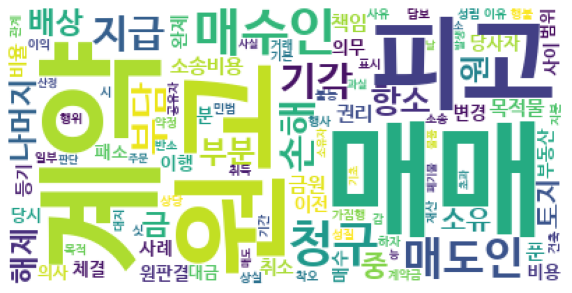

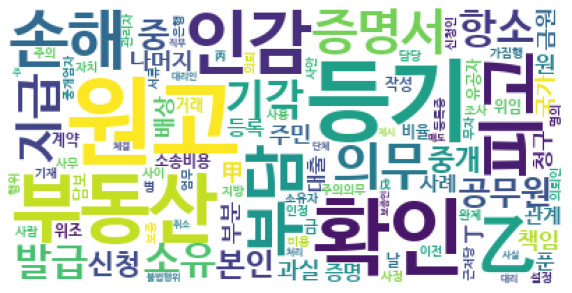

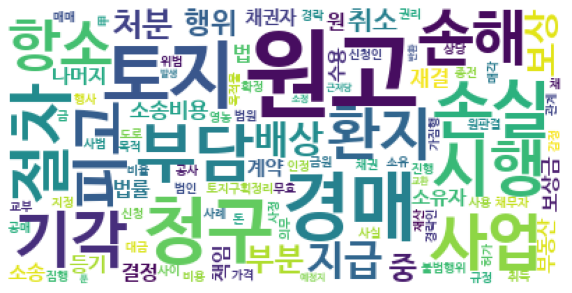

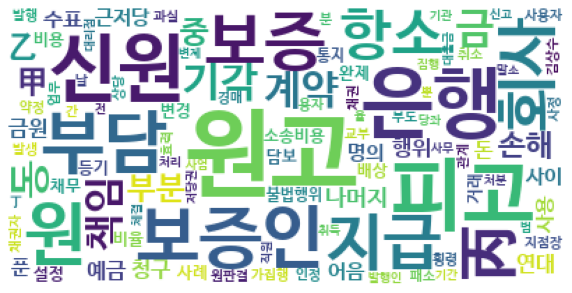

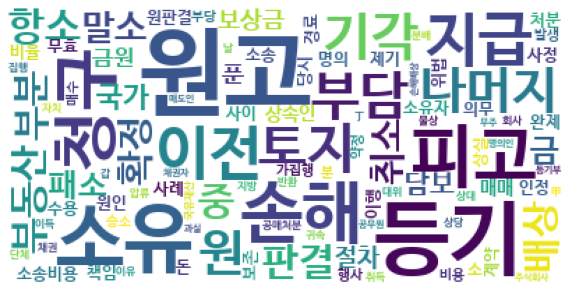

In [151]:
for idx,nouns in enumerate(부동산_nouns_entire):
    num_top_nouns = 100
    nouns_counter = Counter(nouns)
    top_nouns = dict(nouns_counter.most_common(num_top_nouns)[0:])
    print(top_nouns)
    wc = WordCloud(background_color="white", font_path='/Users/byeonghyeon/Documents/GitHub/IndustrialSystemsEngineering_Project/font/NanumBarunGothicBold.ttf')
    wc.generate_from_frequencies(top_nouns)
    # World
    # 많이 나타나는 단어일수록 크게 나타남
    figure = plt.figure()
    figure.set_size_inches(10, 10)
    ax = figure.add_subplot(1, 1, 1)
    ax.axis("off")
    ax.imshow(wc)
    plt.savefig('{}cluster.png'.format(idx+1))
    print(dict(nouns_counter.most_common(num_top_nouns)[0:100]))